In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
# Paramètres du modèle de Hodgkin-Huxley
params_hodgkin_huxley = {
    'C_m': 1.0,    # Capacitance de la membrane par unité de surface (uF/cm^2)
    'g_Na': 120.0, # Conductance maximale des canaux sodium par unité de surface (mS/cm^2)
    'g_K': 36.0,   # Conductance maximale des canaux potassium par unité de surface (mS/cm^2)
    'g_L': 0.3,    # Conductance de fuite maximale par unité de surface (mS/cm^2)
    'E_Na': 50.0,  # Potentiel d'inversion du sodium (mV)
    'E_K': -77.0,  # Potentiel d'inversion du potassium (mV)
    'E_L': -54.387 # Potentiel d'inversion de fuite (mV)
}

In [4]:
# temps pour la simulation
t = np.arange(0.0, 450.0, 0.01)

# fonction définissant le courant entrant pour la simulation
def I_inj1(t):
    return 0*(t>0)

def I_inj2(t):
    return 1*(t>=0)

def I_inj3(t):
    return 2*(t>=0)

def I_inj4(t):
    return 3*(t>=0)

def I_inj5(t):
    return 4*(t>=0)

def I_inj6(t):
    return 5*(t>=0)

def I_inj7(t):
    return 6*(t>=0)

def I_inj8(t):
    return 7*(t>=0)

def I_inj9(t):
    return 8*(t>=0)

def I_inj10(t):
    return 9*(t>=0)

In [5]:
# valeurs initiales de courant global et pour chaque canal ionique
val_init = [-65, 0.05, 0.6, 0.32]

In [6]:
# créé à partir du modèle sur le site https://hodgkin-huxley-tutorial.readthedocs.io/en/latest/index.html
class HodgkinHuxley():
    """Full Hodgkin-Huxley Model implemented in Python"""

    def __init__(self, params):
        self.C_m  =   params['C_m']
        """membrane capacitance, in uF/cm^2"""

        self.g_Na = params['g_Na']
        """Sodium (Na) maximum conductances, in mS/cm^2"""

        self.g_K  =  params['g_K']
        """Postassium (K) maximum conductances, in mS/cm^2"""

        self.g_L  =   params['g_L']
        """Leak maximum conductances, in mS/cm^2"""

        self.E_Na =  params['E_Na']
        """Sodium (Na) Nernst reversal potentials, in mV"""

        self.E_K  = params['E_K']
        """Postassium (K) Nernst reversal potentials, in mV"""

        self.E_L  = params['E_L']
        """Leak Nernst reversal potentials, in mV"""

    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4.0*np.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*np.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*np.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)

        |  :param V:
        |  :param m:
        |  :param h:
        |  :return:
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)
    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)

    @staticmethod
    def dALLdt(X, t, self, I_inj):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X

        dVdt = (I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dmdt, dhdt, dndt

    def simulation(self, t, val_init, I_inj):
        """
        Main demo for the Hodgkin Huxley neuron model
        """

        X = odeint(self.dALLdt, val_init, t, args=(self,I_inj))
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)
    
        return {'V':V, 'm':m, 'h':h, 'n':n, 'ina':ina, 'ik':ik, 'il':il}


In [7]:
# Initialisation du modèle
hh = HodgkinHuxley(params_hodgkin_huxley)
# Exécution de la simulation
resultat1 = hh.simulation(t, val_init, I_inj1)
resultat2 = hh.simulation(t, val_init, I_inj2)
resultat3 = hh.simulation(t, val_init, I_inj3)
resultat4 = hh.simulation(t, val_init, I_inj4)
resultat5 = hh.simulation(t, val_init, I_inj5)
resultat6 = hh.simulation(t, val_init, I_inj6)
resultat7 = hh.simulation(t, val_init, I_inj7)
resultat8 = hh.simulation(t, val_init, I_inj8)
resultat9 = hh.simulation(t, val_init, I_inj9)
resultat10 = hh.simulation(t, val_init, I_inj10)

In [18]:
I_inj_No_tab = (resultat1['V'] + resultat2['V'] +resultat3['V'] +resultat4['V'] +resultat5['V'] +resultat6['V'] +resultat7['V'] +resultat8['V'] +resultat9['V'] +resultat10['V']) / 10

In [24]:
I_inj_No_tab

array([-65.        , -64.95821284, -64.91662963, ..., -59.64565582,
       -59.67536259, -59.70486352])

In [25]:
resultat_No['V']

array([ -65.        ,  -65.65084944,  -66.29726147, ..., -251.96798532,
       -251.97139652, -251.97509628])

In [21]:
def I_inj_No(t):
    if int(t* 100) > 0:
        indice = int((t-0.01)* 100)
        return I_inj_No_tab[indice]
    else:
        return I_inj_No_tab[0]

In [22]:
resultat_No = hh.simulation(t, val_init, I_inj_No)

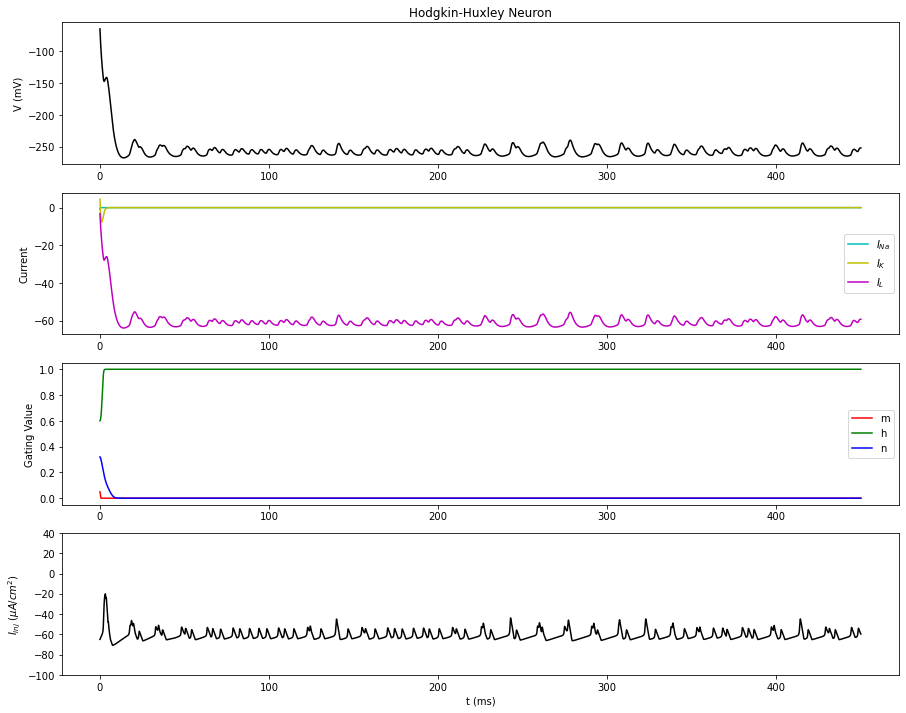

In [28]:
# Affiche les résultats de l'expérience
plt.figure(figsize=(15,12))

plt.subplot(4,1,1)
plt.title('Hodgkin-Huxley Neuron')
plt.plot(t, resultat_No['V'], 'k')
plt.ylabel('V (mV)')

plt.subplot(4,1,2)
plt.plot(t, resultat_No['ina'], 'c', label='$I_{Na}$')
plt.plot(t, resultat_No['ik'], 'y', label='$I_{K}$')
plt.plot(t, resultat_No['il'], 'm', label='$I_{L}$')
plt.ylabel('Current')
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, resultat_No['m'], 'r', label='m')
plt.plot(t, resultat_No['h'], 'g', label='h')
plt.plot(t, resultat_No['n'], 'b', label='n')
plt.ylabel('Gating Value')
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, I_inj_No_tab, 'k')
plt.xlabel('t (ms)')
plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
plt.ylim(-100, 40)

plt.show()

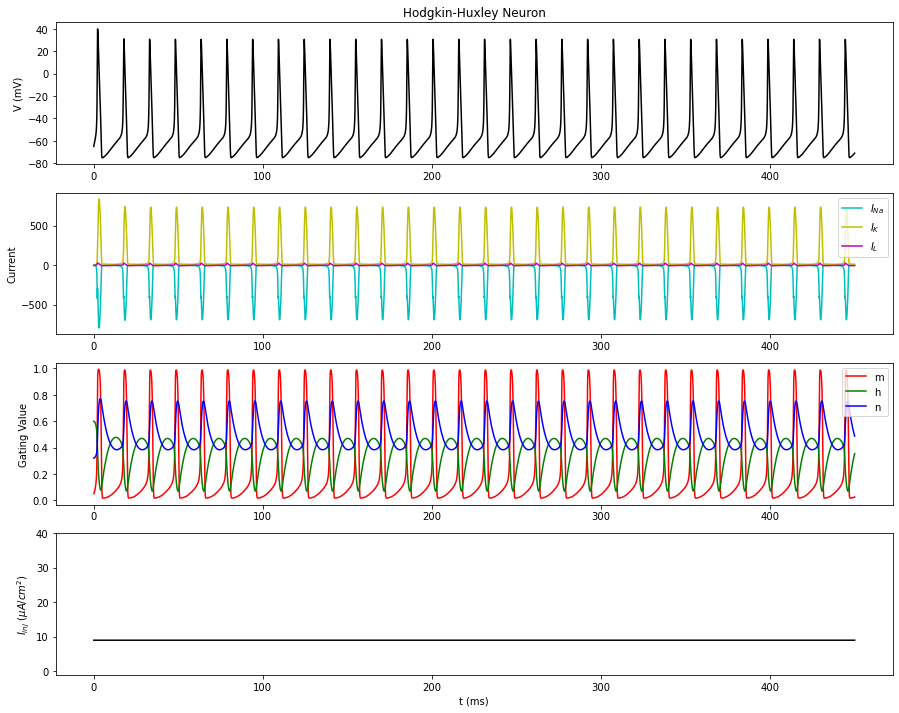

In [13]:
# Affiche les résultats de l'expérience
plt.figure(figsize=(15,12))

plt.subplot(4,1,1)
plt.title('Hodgkin-Huxley Neuron')
plt.plot(t, resultat10['V'], 'k')
plt.ylabel('V (mV)')

plt.subplot(4,1,2)
plt.plot(t, resultat10['ina'], 'c', label='$I_{Na}$')
plt.plot(t, resultat10['ik'], 'y', label='$I_{K}$')
plt.plot(t, resultat10['il'], 'm', label='$I_{L}$')
plt.ylabel('Current')
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, resultat10['m'], 'r', label='m')
plt.plot(t, resultat10['h'], 'g', label='h')
plt.plot(t, resultat10['n'], 'b', label='n')
plt.ylabel('Gating Value')
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, I_inj10(t), 'k')
plt.xlabel('t (ms)')
plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
plt.ylim(-1, 40)

plt.show()